In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import anndata as ad
import pooch

# require a specific version of numpy <2.0

In [2]:
# scanpy official tutorial:
# https://scanpy.readthedocs.io/en/stable/tutorials/index.html

In [3]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [5]:
# data used was part of openproblem’s NeurIPS 2021 benchmarking dataset [Luecken et al., 2021].

In [4]:
# read the data into an AnnData object

EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [10]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

/Users/zhuxingyu/Library/Python/3.10/lib/python/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/zhuxingyu/Library/Python/3.10/lib/python/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/zhuxingyu/Library/Python/3.10/lib/python/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/zhuxingyu/Library/Python/3.10/lib/python/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adatas

sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/Users/zhuxingyu/Library/Python/3.10/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


{'s1d1': AnnData object with n_obs × n_vars = 8785 × 36601
     var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence',
 's1d3': AnnData object with n_obs × n_vars = 8340 × 36601
     var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'}

In [12]:
# containing ~8,000 cells per sample and 36,601 measured genes

# Quality Control

In [14]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [15]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [19]:
list(adata.var_names)

['MIR1302-2HG',
 'FAM138A',
 'OR4F5',
 'AL627309.1',
 'AL627309.3',
 'AL627309.2',
 'AL627309.5',
 'AL627309.4',
 'AP006222.2',
 'AL732372.1',
 'OR4F29',
 'AC114498.1',
 'OR4F16',
 'AL669831.2',
 'LINC01409',
 'FAM87B',
 'LINC01128',
 'LINC00115',
 'FAM41C',
 'AL645608.6',
 'AL645608.2',
 'AL645608.4',
 'LINC02593',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'AL645608.7',
 'HES4',
 'ISG15',
 'AL645608.1',
 'AGRN',
 'AL645608.5',
 'AL645608.8',
 'RNF223',
 'C1orf159',
 'AL390719.3',
 'LINC01342',
 'AL390719.2',
 'TTLL10-AS1',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'AL162741.1',
 'UBE2J2',
 'LINC01786',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'AL139287.1',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20-AS1',
 'MRPL20',
 'AL391244.2',
 'ANKRD65',
 'AL391244.1',
 'TMEM88B',
 'LINC01770',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'AL645728.1',
 'FNDC10',
 'AL691432.4',
 'AL691432.2',
 'MIB2',
 'MMP

- the number of genes expressed in the count matrix

- the total counts per cell

- the percentage of counts in mitochondrial genes

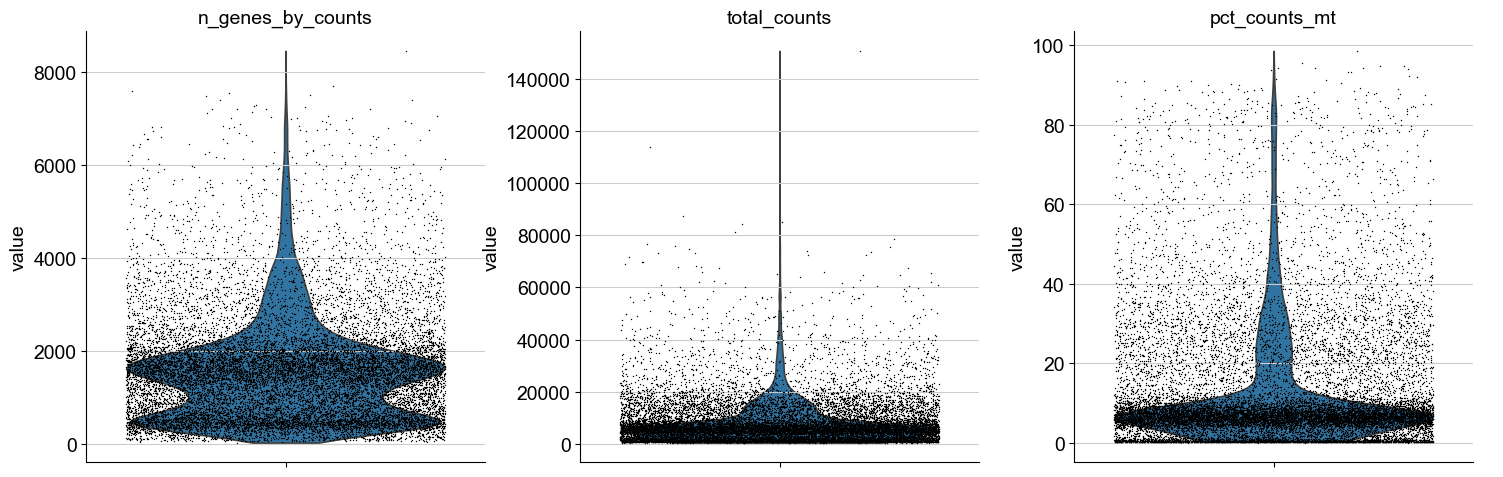

In [20]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

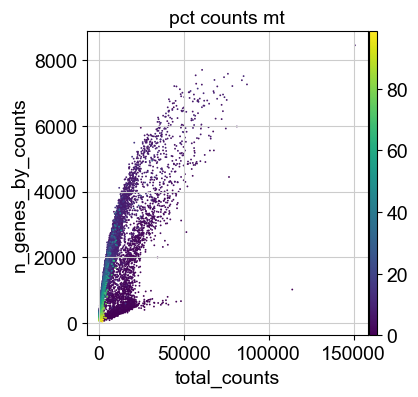

In [24]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Remove genes:
- with too many mitochondrial genes expressed
- too many total counts (by setting manual or automatic thresholds)

> However, sometimes what appears to be poor QC metrics can be driven by real biology so we suggest starting with a very permissive filtering strategy and revisiting it at a later point.

> We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells.

In [25]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Doublet detection